In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import torch
import seaborn as sns
import itertools
from tqdm.auto import tqdm

/private/home/krunolp/.conda/envs/ldm/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


tensor(500)


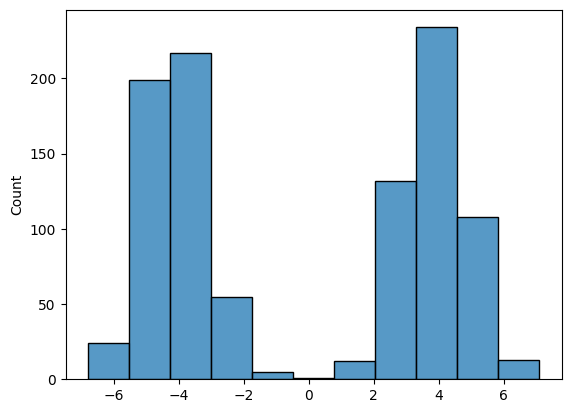

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
torch.manual_seed(0)
data_distribution = torch.distributions.mixture_same_family.MixtureSameFamily(
    torch.distributions.Categorical(torch.tensor([1, 1])),
    torch.distributions.Normal(torch.tensor([-4., 4.]), torch.tensor([1., 1.]))
)

dataset = data_distribution.sample(torch.Size([1000, 1]))
dataset = dataset
labels = (dataset<=0) * 1
print(labels.sum())
sns.histplot(dataset[:, 0])
plt.show()

In [3]:
# we will keep these parameters fixed throughout
TIME_STEPS = 250
BETA = torch.tensor([0.02]).to(device)

In [4]:
def do_diffusion(data, steps=TIME_STEPS, beta=BETA):
    # starting from t=0 (i.e., the dataset)
    # returns a list of q(x(t)) and x(t)

    distributions, samples = [None], [data]
    xt = data
    for t in range(steps):
        q = torch.distributions.Normal(
            torch.sqrt(1 - beta) * xt,
            torch.sqrt(beta),
        )
        xt = q.sample()

        distributions.append(q)
        samples.append(xt)

    return distributions, samples

In [5]:
dataset = dataset.to(device)
_, samples = do_diffusion(dataset)

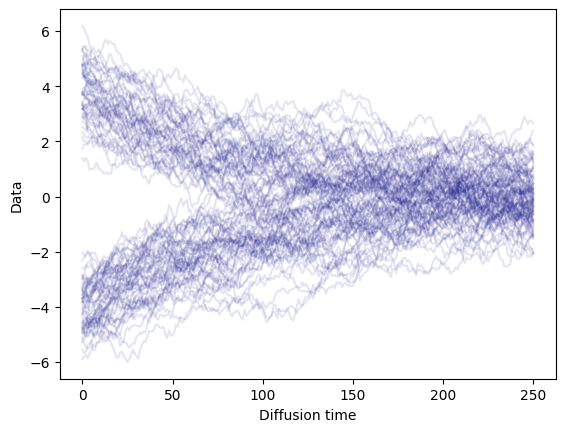

In [6]:
for t in torch.stack(samples)[:, :, 0].T[:100]:
    plt.plot(t.cpu(), c='navy', alpha=0.1)
plt.xlabel('Diffusion time')
plt.ylabel('Data')
plt.show()

In [7]:
import torch.nn.functional as F

def one_hot_encode(labels, num_classes):
    return F.one_hot(labels, num_classes).float()

In [8]:
def compute_loss(forward_distributions, forward_samples, mean_model, var_model, mus, vars):
    # here we compute the loss in equation 3
    # forward = q , reverse = p

    # loss for x(T)
    p = torch.distributions.Normal(mus, vars)
    loss = -p.log_prob(forward_samples[-1]).mean()

    for t in range(1, len(forward_samples)):
        xt = forward_samples[t]         # x(t)
        xprev = forward_samples[t - 1]  # x(t-1)
        q = forward_distributions[t]    # q( x(t) | x(t-1) )

        # normalize t between 0 and 1 and add it as a new column
        # to the inputs of the mu and sigma networks
        xin = torch.cat(
            (xt, (t / len(forward_samples)) * torch.ones(xt.shape[0], 1).to(device)),
            dim=1
        )
        # compute p( x(t-1) | x(t) ) as equation 1
        
        class_info = one_hot_encode(labels, 2).to(device).squeeze()
        if torch.rand(1).item() < 0.1:
            class_info *= 0
            
        inputs = torch.cat((xin, class_info), dim=1).to(device)

        mu = mean_model(inputs)
        sigma = var_model(inputs)
        p = torch.distributions.Normal(mu, sigma)

        # add a term to the loss
        loss -= torch.mean(p.log_prob(xprev.to(device)))
        loss += torch.mean(q.log_prob(xt)).to(device)

    return loss / len(forward_samples)

In [9]:
num_classes = 2

mean_model = torch.nn.Sequential(
    torch.nn.Linear(2 + num_classes, 4), 
    torch.nn.ReLU(),
    torch.nn.Linear(4, 1)
)
var_model = torch.nn.Sequential(
    torch.nn.Linear(2 + num_classes, 4),
    torch.nn.ReLU(),
    torch.nn.Linear(4, 1),
    torch.nn.Softplus()
)

In [10]:
# num_classes = 2
# mean_model = torch.nn.Sequential(
#     torch.nn.Linear(2 + num_classes, 16),  
#     torch.nn.ReLU(),
#     torch.nn.Linear(16, 8),               
#     torch.nn.ReLU(),
#     torch.nn.Linear(8, 1)
# )
# var_model = torch.nn.Sequential(
#     torch.nn.Linear(2 + num_classes, 16),  
#     torch.nn.ReLU(),
#     torch.nn.Linear(16, 8),               
#     torch.nn.ReLU(),
#     torch.nn.Linear(8, 1),
#     torch.nn.Softplus()
# )

In [11]:
optim = torch.optim.AdamW(
    itertools.chain(mean_model.parameters(), var_model.parameters()),
    lr=1e-2, weight_decay=1e-6,
)


In [12]:
len(samples)

251

In [13]:
loss_history = []
bar = tqdm(range(1000))

mus, vars =  torch.zeros(len(samples)).to(device), torch.ones(len(samples)).to(device)
for e in bar:
    forward_distributions, forward_samples = do_diffusion(dataset)

    optim.zero_grad()
    loss = compute_loss(
        forward_distributions, forward_samples, mean_model, var_model, mus, vars
    )
    loss.backward()
    optim.step()

    bar.set_description(f'Loss: {loss.item():.4f}')
    loss_history.append(loss.item())

  0%|          | 0/1000 [00:00<?, ?it/s]

Loss: 0.0150: 100%|██████████| 1000/1000 [05:41<00:00,  2.93it/s]


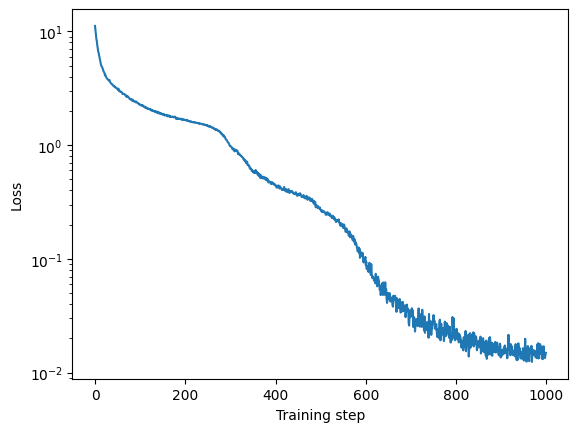

In [14]:
plt.plot(loss_history)
plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Training step')
plt.show()

In [24]:
def sample_reverse(mean_model, var_model, count, steps=TIME_STEPS, cfg=False, omega=0.):
    p = torch.distributions.Normal(torch.zeros(count, 1), torch.ones(count, 1))
    xt = p.sample()
    sample_history = [xt]
    for t in range(steps, 0, -1):
        xin = torch.cat((xt, t * torch.ones(xt.shape) / steps), dim=1)
        labels = torch.zeros((xin.shape[0], 1)).long()+1
        class_info = one_hot_encode(labels, 2).to(device).squeeze()
        inputs = torch.cat((xin, class_info), dim=1).to(device)
        p = torch.distributions.Normal(
            mean_model(inputs), var_model(inputs)
        )
        xt = p.sample()
        if cfg:
            inputs = torch.cat((xin, class_info*0), dim=1).to(device)
            p = torch.distributions.Normal(mean_model(inputs), var_model(inputs))
            xt_cfg = p.sample()
            xt = (1+omega) * xt - omega * xt_cfg
        sample_history.append(xt)
    return sample_history

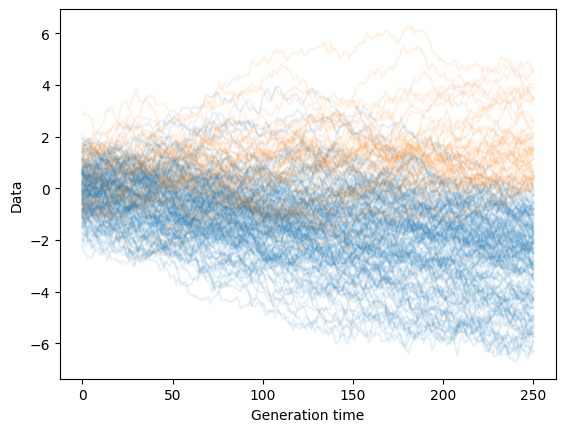

In [25]:
samps = torch.stack(sample_reverse(mean_model, var_model, 1000, cfg=False, omega=.5))
for t in samps[:,:,0].T[:200]:
    plt.plot(t, c='C%d' % int(t[-1] > 0), alpha=0.1)
plt.xlabel('Generation time')
plt.ylabel('Data')
plt.show()

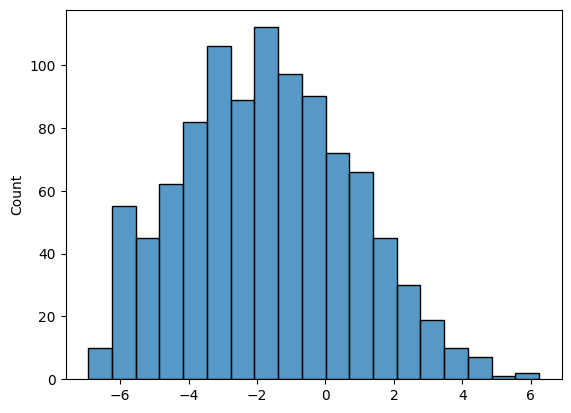

In [26]:
sns.histplot(samps[-1, :, 0])
plt.show()